# Installing Packages

In [1]:
!pip install albumentations==0.4.5

In [2]:
pip install torch-lr-finder -v --global-option="amp"

Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
Config variable 'WITH_PYMALLOC' is unset, Python ABI tag may be incorrect
Created temporary directory: C:\Users\divva\AppData\Local\Temp\pip-ephem-wheel-cache-w8iuy7iv
Created temporary directory: C:\Users\divva\AppData\Local\Temp\pip-req-tracker-s1ki3l96
Created requirements tracker 'C:\\Users\\divva\\AppData\\Local\\Temp\\pip-req-tracker-s1ki3l96'
Created temporary directory: C:\Users\divva\AppData\Local\Temp\pip-install-jrob1n9n
Cleaning up...
Removed build tracker 'C:\\Users\\divva\\AppData\\Local\\Temp\\pip-req-tracker-s1ki3l96'
Note: you may need to restart the kernel to use updated packages.


C:\Users\divva\Anaconda3\lib\site-packages\pip\_internal\commands\install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


# Imports
Importing necessary packages and modules

In [3]:
%matplotlib inline

import random

from torchsummary import summary

from cuda import initialize_cuda
from data.dataset import CIFAR10
from model import ResNet18
from model.utils.loss import cross_entropy_loss
from model.utils.optimizers import sgd_optimizer
from model.utils.callbacks import lr_scheduler
from model.utils.callbacks import reduceLRonplateau
from gradcam import GradCAMView
from train import train
from evaluate import val
from result import plot_metric, save_and_show_result
from LR_finder.lr_finder import LRFinder
import torch

C:\Users\divva\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
  pip install torch-lr-finder -v --global-option="amp"


# Configuration

Set various parameters and hyperparameters

In [4]:
class Args:

    # Data Loading
    # ============

    train_batch_size = 64
    val_batch_size = 64
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.2
    vertical_flip_prob = 0.0
    gaussian_blur_prob = 0.0
    rotate_degree = 20
    cutout = 0.3

    # Training
    # ========
    random_seed = 1
    epochs = 50
    learning_rate = 0.01
    momentum = 0.9
    lr_step_size = 25
    lr_gamma = 0.1

    # Evaluation
    # ==========
    sample_count = 25

## Set Seed and Get GPU Availability

In [5]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(Args.random_seed)

GPU Available? True


## Download Dataset

Importing the CIFAR-10 class to download dataset and create data loader

In [6]:
dataset = CIFAR10(
    train_batch_size=Args.train_batch_size,
    val_batch_size=Args.val_batch_size,
    cuda=cuda,
    num_workers=Args.num_workers,
    horizontal_flip_prob=Args.horizontal_flip_prob,
    vertical_flip_prob=Args.vertical_flip_prob,
    gaussian_blur_prob=Args.gaussian_blur_prob,
    rotate_degree=Args.rotate_degree,
    cutout=Args.cutout
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [7]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

In [8]:
model = ResNet18().to(device)  # Create model
summary(model, dataset.image_size)  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Model Training and Validation

In [9]:
losses = []
accuracies = []
correct_samples = []
incorrect_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd_optimizer(model, 1e-7, Args.momentum)  # Create optimizer

lr_finderr = LRFinder(model,optimizer,criterion,device = "cuda")
lr_finderr.range_test(train_loader, end_lr=10, num_iter=400,step_mode = "exp")


Learning rate search finished. See the graph with {finder_name}.plot()


Best LR to start with:  0.009549925860214368
Corresponding loss:  1.8717587295355875


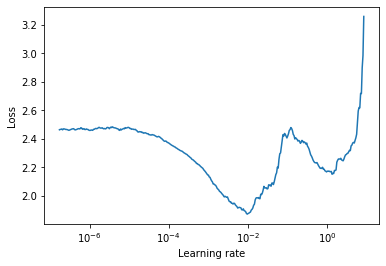

In [12]:
#The best initial learning rate
#best_init_lr = lr_finderr.best_lr
#print(lr_finderr.best_lr)

print("Best LR to start with: ",lr_finderr.best_lr)
print("Corresponding loss: ", lr_finderr.best_loss)

# to inspect the loss-learning rate graph
lr_finderr.plot()

# to reset the model and optimizer to their initial state
lr_finderr.reset() 

In [14]:
optimizer = sgd_optimizer(model, 0.009, Args.momentum)  # Create optimizer
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, 
                                           verbose=False, threshold=0.0001, threshold_mode='rel',
                                           cooldown=0, min_lr=1e-4, eps=1e-08)
scheduler = lr_scheduler(optimizer, Args.lr_step_size, Args.lr_gamma)
last_epoch = False

for epoch in range(1, Args.epochs + 1):
    print(f'Epoch {epoch}:')
    if epoch == Args.epochs:
        last_epoch = True
    train(model, train_loader, device, optimizer, criterion)
    scheduler.step()
    val(
        model, val_loader, device, criterion, losses, accuracies,
        correct_samples, incorrect_samples, Args.sample_count, last_epoch=last_epoch
    )

Epoch 1:


Loss=0.55 Batch_ID=781 Accuracy=50.21: 100%|█████████████████████████████████████████| 782/782 [01:53<00:00,  7.39it/s]



Validation set: Average loss: 0.0163, Accuracy: 6348/10000 (63.48%)

Epoch 2:


Loss=0.43 Batch_ID=781 Accuracy=68.48: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.41it/s]



Validation set: Average loss: 0.0118, Accuracy: 7360/10000 (73.60%)

Epoch 3:


Loss=0.89 Batch_ID=781 Accuracy=75.47: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.42it/s]



Validation set: Average loss: 0.0120, Accuracy: 7428/10000 (74.28%)

Epoch 4:


Loss=0.33 Batch_ID=781 Accuracy=78.95: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.33it/s]



Validation set: Average loss: 0.0088, Accuracy: 8076/10000 (80.76%)

Epoch 5:


Loss=0.84 Batch_ID=781 Accuracy=81.91: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.42it/s]



Validation set: Average loss: 0.0095, Accuracy: 7994/10000 (79.94%)

Epoch 6:


Loss=0.47 Batch_ID=781 Accuracy=83.75: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.40it/s]



Validation set: Average loss: 0.0080, Accuracy: 8320/10000 (83.20%)

Epoch 7:


Loss=0.46 Batch_ID=781 Accuracy=85.61: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.34it/s]



Validation set: Average loss: 0.0098, Accuracy: 8022/10000 (80.22%)

Epoch 8:


Loss=0.57 Batch_ID=781 Accuracy=86.72: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.35it/s]



Validation set: Average loss: 0.0075, Accuracy: 8432/10000 (84.32%)

Epoch 9:


Loss=0.58 Batch_ID=781 Accuracy=88.05: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.46it/s]



Validation set: Average loss: 0.0073, Accuracy: 8469/10000 (84.69%)

Epoch 10:


Loss=0.44 Batch_ID=781 Accuracy=89.43: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.39it/s]



Validation set: Average loss: 0.0076, Accuracy: 8500/10000 (85.00%)

Epoch 11:


Loss=0.42 Batch_ID=781 Accuracy=90.01: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.36it/s]



Validation set: Average loss: 0.0064, Accuracy: 8625/10000 (86.25%)

Epoch 12:


Loss=0.29 Batch_ID=781 Accuracy=91.12: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.36it/s]



Validation set: Average loss: 0.0063, Accuracy: 8701/10000 (87.01%)

Epoch 13:


Loss=0.27 Batch_ID=781 Accuracy=91.76: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.40it/s]



Validation set: Average loss: 0.0064, Accuracy: 8727/10000 (87.27%)

Epoch 14:


Loss=0.11 Batch_ID=781 Accuracy=92.07: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.38it/s]



Validation set: Average loss: 0.0066, Accuracy: 8693/10000 (86.93%)

Epoch 15:


Loss=0.10 Batch_ID=781 Accuracy=92.64: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.40it/s]



Validation set: Average loss: 0.0067, Accuracy: 8722/10000 (87.22%)

Epoch 16:


Loss=0.03 Batch_ID=781 Accuracy=93.33: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.32it/s]



Validation set: Average loss: 0.0063, Accuracy: 8755/10000 (87.55%)

Epoch 17:


Loss=0.09 Batch_ID=781 Accuracy=93.75: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.37it/s]



Validation set: Average loss: 0.0062, Accuracy: 8787/10000 (87.87%)

Epoch 18:


Loss=0.14 Batch_ID=781 Accuracy=93.94: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.37it/s]



Validation set: Average loss: 0.0062, Accuracy: 8833/10000 (88.33%)

Epoch 19:


Loss=0.30 Batch_ID=781 Accuracy=94.43: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.30it/s]



Validation set: Average loss: 0.0072, Accuracy: 8692/10000 (86.92%)

Epoch 20:


Loss=0.15 Batch_ID=781 Accuracy=94.73: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.34it/s]



Validation set: Average loss: 0.0057, Accuracy: 8880/10000 (88.80%)

Epoch 21:


Loss=0.05 Batch_ID=781 Accuracy=95.02: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.34it/s]



Validation set: Average loss: 0.0062, Accuracy: 8846/10000 (88.46%)

Epoch 22:


Loss=0.48 Batch_ID=781 Accuracy=95.10: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.37it/s]



Validation set: Average loss: 0.0059, Accuracy: 8871/10000 (88.71%)

Epoch 23:


Loss=0.11 Batch_ID=781 Accuracy=95.51: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.35it/s]



Validation set: Average loss: 0.0058, Accuracy: 8892/10000 (88.92%)

Epoch 24:


Loss=0.01 Batch_ID=781 Accuracy=95.89: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.36it/s]



Validation set: Average loss: 0.0061, Accuracy: 8905/10000 (89.05%)

Epoch 25:


Loss=0.01 Batch_ID=781 Accuracy=95.93: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.39it/s]



Validation set: Average loss: 0.0060, Accuracy: 8880/10000 (88.80%)

Epoch 26:


Loss=0.08 Batch_ID=781 Accuracy=97.25: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.34it/s]



Validation set: Average loss: 0.0050, Accuracy: 9065/10000 (90.65%)

Epoch 27:


Loss=0.42 Batch_ID=781 Accuracy=97.82: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.36it/s]



Validation set: Average loss: 0.0050, Accuracy: 9074/10000 (90.74%)

Epoch 28:


Loss=0.04 Batch_ID=781 Accuracy=97.92: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.32it/s]



Validation set: Average loss: 0.0050, Accuracy: 9080/10000 (90.80%)

Epoch 29:


Loss=0.24 Batch_ID=781 Accuracy=98.11: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.42it/s]



Validation set: Average loss: 0.0050, Accuracy: 9079/10000 (90.79%)

Epoch 30:


Loss=0.01 Batch_ID=781 Accuracy=98.23: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.34it/s]



Validation set: Average loss: 0.0050, Accuracy: 9076/10000 (90.76%)

Epoch 31:


Loss=0.07 Batch_ID=781 Accuracy=98.35: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.36it/s]



Validation set: Average loss: 0.0049, Accuracy: 9092/10000 (90.92%)

Epoch 32:


Loss=0.05 Batch_ID=781 Accuracy=98.30: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.35it/s]



Validation set: Average loss: 0.0049, Accuracy: 9104/10000 (91.04%)

Epoch 33:


Loss=0.09 Batch_ID=781 Accuracy=98.38: 100%|█████████████████████████████████████████| 782/782 [02:05<00:00,  7.40it/s]



Validation set: Average loss: 0.0049, Accuracy: 9096/10000 (90.96%)

Epoch 34:


Loss=0.10 Batch_ID=781 Accuracy=98.42: 100%|█████████████████████████████████████████| 782/782 [01:53<00:00,  7.41it/s]



Validation set: Average loss: 0.0050, Accuracy: 9102/10000 (91.02%)

Epoch 35:


Loss=0.16 Batch_ID=781 Accuracy=98.37: 100%|█████████████████████████████████████████| 782/782 [01:53<00:00,  7.40it/s]



Validation set: Average loss: 0.0049, Accuracy: 9104/10000 (91.04%)

Epoch 36:


Loss=0.09 Batch_ID=781 Accuracy=98.49: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.41it/s]



Validation set: Average loss: 0.0049, Accuracy: 9111/10000 (91.11%)

Epoch 37:


Loss=0.21 Batch_ID=781 Accuracy=98.47: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.43it/s]



Validation set: Average loss: 0.0049, Accuracy: 9127/10000 (91.27%)

Epoch 38:


Loss=0.08 Batch_ID=781 Accuracy=98.51: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.40it/s]



Validation set: Average loss: 0.0050, Accuracy: 9097/10000 (90.97%)

Epoch 39:


Loss=0.02 Batch_ID=781 Accuracy=98.53: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.39it/s]



Validation set: Average loss: 0.0049, Accuracy: 9121/10000 (91.21%)

Epoch 40:


Loss=0.05 Batch_ID=781 Accuracy=98.63: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.44it/s]



Validation set: Average loss: 0.0050, Accuracy: 9139/10000 (91.39%)

Epoch 41:


Loss=0.00 Batch_ID=781 Accuracy=98.56: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.36it/s]



Validation set: Average loss: 0.0049, Accuracy: 9124/10000 (91.24%)

Epoch 42:


Loss=0.01 Batch_ID=781 Accuracy=98.67: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.38it/s]



Validation set: Average loss: 0.0050, Accuracy: 9127/10000 (91.27%)

Epoch 43:


Loss=0.03 Batch_ID=781 Accuracy=98.58: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.41it/s]



Validation set: Average loss: 0.0050, Accuracy: 9132/10000 (91.32%)

Epoch 44:


Loss=0.09 Batch_ID=781 Accuracy=98.68: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.42it/s]



Validation set: Average loss: 0.0050, Accuracy: 9138/10000 (91.38%)

Epoch 45:


Loss=0.09 Batch_ID=781 Accuracy=98.71: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.40it/s]



Validation set: Average loss: 0.0050, Accuracy: 9113/10000 (91.13%)

Epoch 46:


Loss=0.01 Batch_ID=781 Accuracy=98.76: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.41it/s]



Validation set: Average loss: 0.0050, Accuracy: 9126/10000 (91.26%)

Epoch 47:


Loss=0.17 Batch_ID=781 Accuracy=98.75: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.39it/s]



Validation set: Average loss: 0.0051, Accuracy: 9115/10000 (91.15%)

Epoch 48:


Loss=0.02 Batch_ID=781 Accuracy=98.78: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.42it/s]



Validation set: Average loss: 0.0052, Accuracy: 9121/10000 (91.21%)

Epoch 49:


Loss=0.24 Batch_ID=781 Accuracy=98.74: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.40it/s]



Validation set: Average loss: 0.0050, Accuracy: 9131/10000 (91.31%)

Epoch 50:


Loss=0.11 Batch_ID=781 Accuracy=98.89: 100%|█████████████████████████████████████████| 782/782 [01:54<00:00,  7.43it/s]



Validation set: Average loss: 0.0050, Accuracy: 9136/10000 (91.36%)



## Plotting Results

Plot changes in validation loss

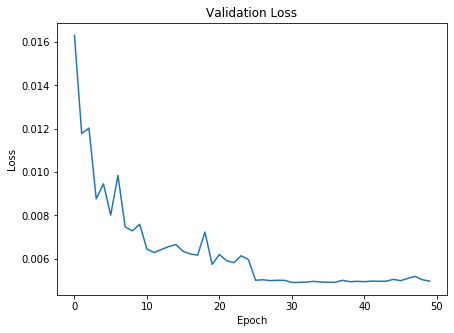

In [15]:
plot_metric(
    {'Training': train_accuracies, 'Validation': val_accuracies}, 'Accuracy'
)

Plot changes in validation accuracy

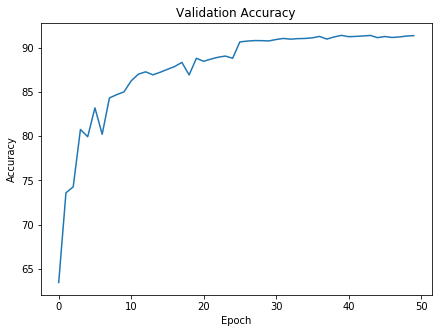

In [16]:
plot_metric(accuracies, 'Accuracy')

### GradCAM

Let's display GradCAM of any random 2 correctly predicted samples

Mode set to GradCAM.


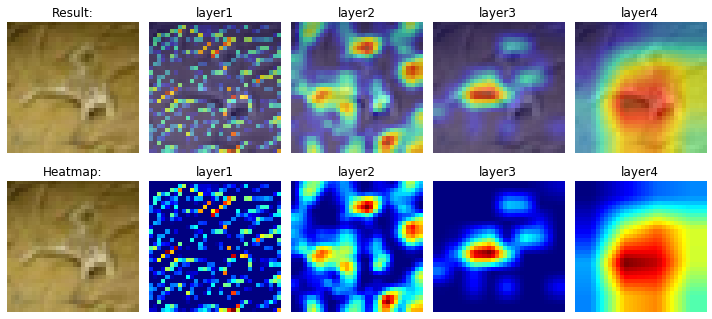

<Figure size 432x288 with 0 Axes>

In [21]:
grad_cam = GradCAMView(
    model, ['layer1', 'layer2', 'layer3', 'layer4'],
    device, dataset.mean, dataset.std
)

for x in random.sample(incorrect_samples, 25):
    images = [x['image']]
grad_cam(images, 'grad_cam')

## Display Correct and Incorrect Predictions

In [ ]:
save_and_show_result(correct_samples, incorrect_samples, dataset.classes)

In [25]:
def plot_gradcam(cam_data, pred_data, classes, plot_name):
    # Initialize plot
    fig, axs = plt.subplots(len(cam_data), 2, figsize=(4, 60))

    for idx in range(len(cam_data)):
        label = classes[pred_data[idx]['label']]
        prediction = classes[pred_data[idx]['prediction']]

        axs[idx][0].axis('off')
        axs[idx][0].set_title(f'Image: {idx + 1}\nLabel: {label}')
        axs[idx][0].imshow(cam_data[idx]['image'])

        axs[idx][1].axis('off')
        axs[idx][1].set_title(f'GradCAM: {idx + 1}\nPrediction: {prediction}')
        axs[idx][1].imshow(cam_data[idx]['result']['layer4'])
    
    # Set spacing
    fig.tight_layout()
    fig.subplots_adjust(top=1.1)

    # Save image
    fig.savefig(plot_name, bbox_inches='tight')

TypeError: 'AxesSubplot' object is not subscriptable

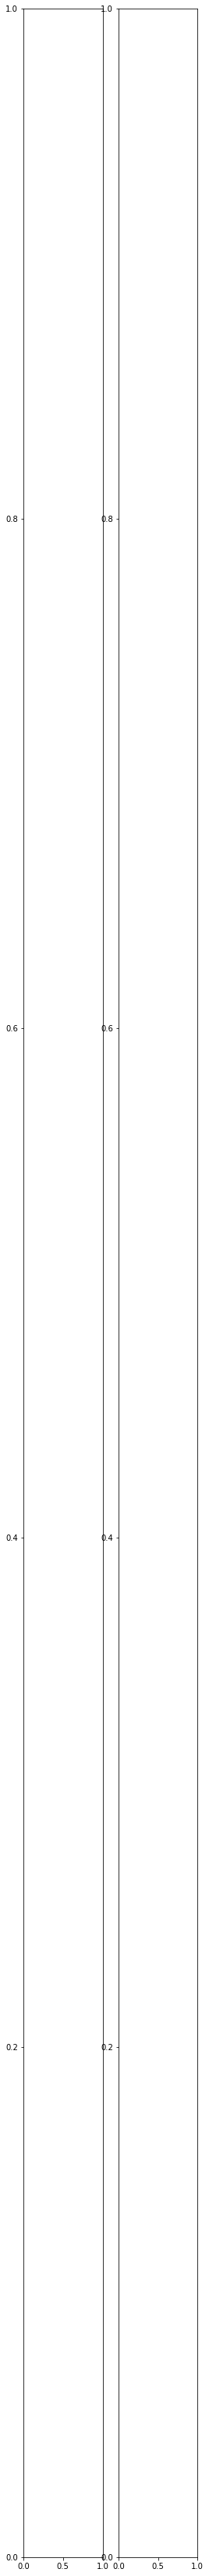

In [26]:
plot_gradcam(gradcam_views, incorrect_samples, dataset.classes, 'pred_gradcam.png')